## 2: Dataset2 3-Digit Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

Shape: (84, 84)
Range: 0.0-1.0


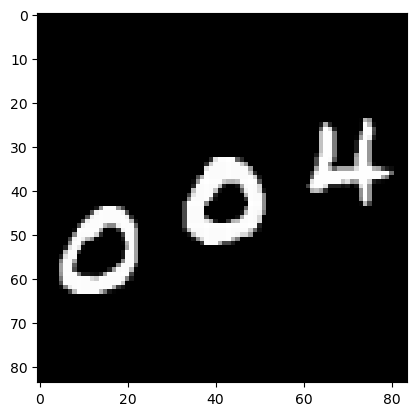

In [2]:
img = mpimg.imread('dataset2/triple_mnist/train/004/14_004.png')
imgplot = plt.imshow(img, cmap='gray')
print('Shape: ' + str(img.shape))
print('Range: ' + str(np.min(img)) + '-' + str(np.max(img)))

### Data Importing

In [3]:
import os

def get_data(subdir):
    # this imports all the data from a specified subdirectory and places into [img, label] pairs in a list.
    dir = 'dataset2/triple_mnist'  # base directory for all data.
    X = []
    y = []
    labels = os.listdir(os.path.join(dir, subdir))  # get all folders (labels) in the subdirectory.
    
    for label in labels:  # cycles through each folder (label).

        for img in os.listdir(os.path.join(dir, subdir, label)):  # cycles through each png.
            try:
                img_arr = plt.imread(os.path.join(dir, subdir, label, img))  # reads image data.
                X.append(img_arr)  # appends image data with label.
                y.append([int(digit) for digit in label])
            except Exception as e:
                print(e)

    return np.array(X), np.array(y)

In [4]:
X_train, y_train = get_data('train')
X_val, y_val = get_data('val')
X_test, y_test = get_data('test')

In [5]:
print(X_train.shape)
print(y_train.shape)

(64000, 84, 84)
(64000, 3)


### Thresholding

(0.1, 1.0)

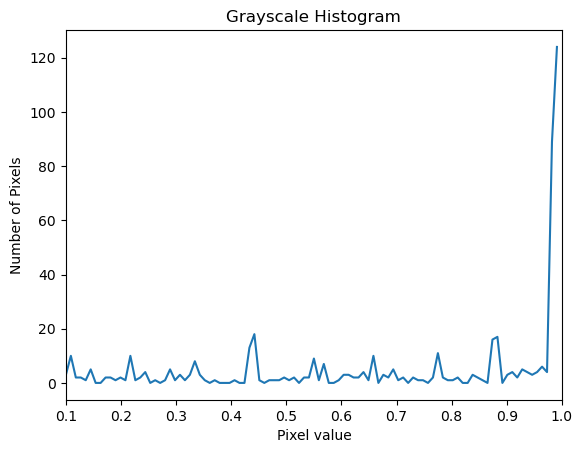

In [6]:
sample_img = mpimg.imread('dataset2/triple_mnist/train/248/14_248.png')
histogram, bin_edges = np.histogram(sample_img, bins=100, range=(0.1, 1.0))  # histogram of pixel values.

# PLOTTING HISTOGRAM
fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)
ax.set_title("Grayscale Histogram")
ax.set_xlabel("Pixel value")
ax.set_ylabel("Number of Pixels")
ax.set_xlim(0.1, 1.0)  # 0.1 is used as lower limit because there are thousands of 0 pixels that flood the graph.

In [7]:
def thresholding(X_data, threshold):
    X_new = []

    for img in X_data:
        binary_img = img > threshold
        X_new.append(binary_img)

    return np.array(X_new)

In [8]:
t = 0.4
X_train_mod = thresholding(X_train, threshold=t)
X_val_mod = thresholding(X_val, threshold=t)
X_test_mod = thresholding(X_test, threshold=t)

Text(0.5, 1.0, 'After Thresholding')

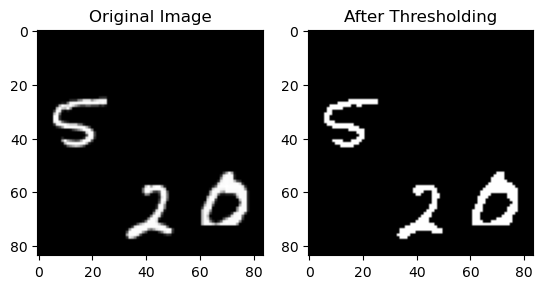

In [9]:
i1 = random.randint(0, len(X_train))

plt.subplot(1, 2, 1)
plt.imshow(X_train[i1], cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(X_train_mod[i1], cmap='gray')
plt.title('After Thresholding')

### CNN Model

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import SparseCategoricalAccuracy

In [11]:
''' MODEL 3 AND 4 '''
# # Define the model
# inputs = Input(shape=(84, 84, 1))

# # Convolutional layers with Dropout
# x = Conv2D(64, kernel_size=(3, 3), activation='relu')(inputs)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
# x = MaxPooling2D(pool_size=(2, 2))(x)
# x = Dropout(0.25)(x)

# x = Flatten()(x)

# # Output layers for each digit
# digit1 = Dense(10, activation='softmax', name='digit1')(x)
# digit2 = Dense(10, activation='softmax', name='digit2')(x)
# digit3 = Dense(10, activation='softmax', name='digit3')(x)

' MODEL 3 AND 4 '

In [12]:
''' MODEL 5 '''
# Define the model
inputs = Input(shape=(84, 84, 1))

# Convolutional layers with Dropout
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

x = Flatten()(x)

# Output layers for each digit
digit1 = Dense(10, activation='softmax', name='digit1')(x)
digit2 = Dense(10, activation='softmax', name='digit2')(x)
digit3 = Dense(10, activation='softmax', name='digit3')(x)

In [13]:
# Create the model
model = Model(inputs=inputs, outputs=[digit1, digit2, digit3])

# Compile the model
model.compile(optimizer='adam',
              loss={'digit1': 'sparse_categorical_crossentropy', 'digit2': 'sparse_categorical_crossentropy', 'digit3': 'sparse_categorical_crossentropy'},
              metrics=['accuracy', 'accuracy', 'accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 84, 84, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 82, 82,    │      1,280 │ input_layer[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 41, 41,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 41, 41,    │        512 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 41, 41,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 39, 39,    │     73,792 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 19, 19,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 19,    │        256 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 19, 19,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 17, 17,    │     18,464 │ dropout_1[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 8, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 32)  │        128 │ max_pooling2d_2[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8, 8, 32)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit1 (Dense)      │ (None, 10)        │     20,490 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit2 (Dense)      │ (None, 10)        │     20,490 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ digit3 (Dense)      │ (None, 10)        │     20,490 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 155,902 (608.99 KB)

 Trainable params: 155,454 (607.24 KB)

 Non-trainable params: 448 (1.75 KB)

In [14]:
# TRAINING
history = model.fit(X_train_mod, 
                    {'digit1': y_train[:, 0], 'digit2': y_train[:, 1], 'digit3': y_train[:, 2]},
                    validation_data=(X_val_mod, {'digit1': y_val[:, 0], 'digit2': y_val[:, 1], 'digit3': y_val[:, 2]}),
                    epochs=15,
                    batch_size=64)

Epoch 1/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 972s 967ms/step - digit1_accuracy: 0.4607 - digit2_accuracy: 0.4686 - digit3_accuracy: 0.4052 - loss: 5.2140 - val_digit1_accuracy: 0.8841 - val_digit2_accuracy: 0.8496 - val_digit3_accuracy: 0.8164 - val_loss: 1.4894
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 964s 964ms/step - digit1_accuracy: 0.9197 - digit2_accuracy: 0.9164 - digit3_accuracy: 0.8836 - loss: 0.8873 - val_digit1_accuracy: 0.8184 - val_digit2_accuracy: 0.8386 - val_digit3_accuracy: 0.8431 - val_loss: 1.6514
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 922s 921ms/step - digit1_accuracy: 0.9463 - digit2_accuracy: 0.9438 - digit3_accuracy: 0.9195 - loss: 0.6081 - val_digit1_accuracy: 0.8811 - val_digit2_accuracy: 0.8904 - val_digit3_accuracy: 0.8332 - val_loss: 1.2903
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 923s 923ms/step - digit1_accuracy: 0.9569 - digit2_accuracy: 0.9551 - digit3_accuracy: 0.9378 - loss: 0.4808 - val_digit1_accuracy: 0.9605 - val_digit2_accuracy: 0.9582 - val_dig

In [15]:
# TESTING
test_scores = model.evaluate(X_test_mod, {'digit1': y_test[:, 0], 'digit2': y_test[:, 1], 'digit3': y_test[:, 2]})
print(f"Test loss: {test_scores[0]}")
print(f"Test accuracy for digit 1: {test_scores[-3]}")
print(f"Test accuracy for digit 2: {test_scores[-2]}")
print(f"Test accuracy for digit 3: {test_scores[-1]}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 69s 109ms/step - digit1_accuracy: 0.9859 - digit2_accuracy: 0.9851 - digit3_accuracy: 0.9829 - loss: 0.1421
Test loss: 0.14935624599456787
Test accuracy for digit 1: 0.9849500060081482
Test accuracy for digit 2: 0.985450029373169
Test accuracy for digit 3: 0.982200026512146


In [16]:
y_pred = model.predict(X_test_mod)

625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step


[[6289    1    2    0    0    3    2    0    2    1]
 [ 140 5639   12    0    0    0    0    8    1    0]
 [ 144    1 4747    2    0    0    0    4    2    0]
 [ 160    0    4 5631    0    1    0    2    2    0]
 [ 514    9    5    0 6037    0    2    1    2   30]
 [ 276    0    0   10    0 6407    3    2    2    0]
 [ 339    5    1    1    2    1 6150    0    1    0]
 [ 163    1    5    0    0    0    0 4829    0    2]
 [ 269    0    7    2    0    5    4    0 6410    3]
 [ 253    0    2    1    6    4    0   10    2 5422]]


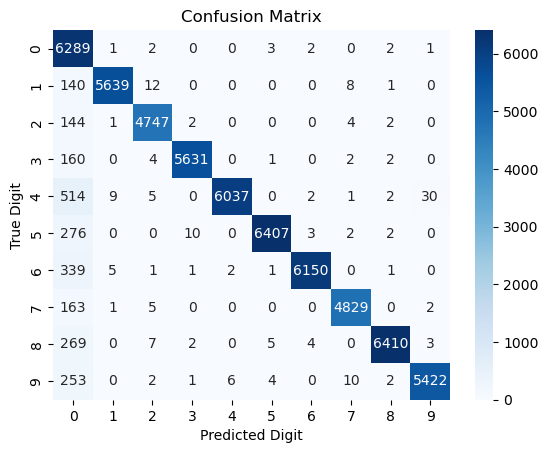

In [17]:
#create confusion maxtrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

thresholded_predictions = [(pred > 0.9).astype(int) for pred in y_pred]
digit1_classes = np.argmax(thresholded_predictions[0], axis=1)
digit2_classes = np.argmax(thresholded_predictions[1], axis=1)
digit3_classes = np.argmax(thresholded_predictions[2], axis=1)

# Convert the true labels to 1D arrays
y_true = np.concatenate([y_test[:, 0], y_test[:, 1], y_test[:, 2]])

# Convert the predicted labels to 1D arrays
y_pred = np.concatenate([digit1_classes, digit2_classes, digit3_classes])

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)


# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Digit')
plt.ylabel('True Digit')
plt.show()

In [18]:
combined_numbers = [f"{d1}{d2}{d3}" for d1, d2, d3 in zip(digit1_classes, digit2_classes, digit3_classes)]

test = [9 9 8]  ===> predicted = 998
test = [3 4 2]  ===> predicted = 342
test = [8 6 6]  ===> predicted = 866
test = [0 4 6]  ===> predicted = 040
test = [0 6 7]  ===> predicted = 067
test = [0 9 9]  ===> predicted = 099
test = [3 4 0]  ===> predicted = 340
test = [1 1 1]  ===> predicted = 111
test = [5 7 6]  ===> predicted = 576
test = [1 4 1]  ===> predicted = 141


c:\Users\jackp\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


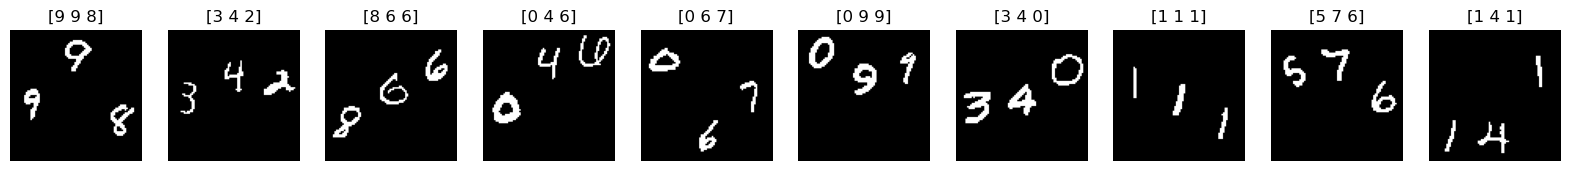

In [19]:
import random

# Set the random seed for reproducibility
random.seed(42)

# Pick 20 random indices
# Print the corresponding y_test and x_test values

from random import Random
rand = Random()
plt.figure(figsize=(20, 2))
for i in range(0, 10):
    plt.subplot(1,10, i + 1)
    x = rand.randint(0, len(X_test_mod) - 1)  # select a random index from x_train data
    print(f'test = {y_test[x]}  ===> predicted = {combined_numbers[x]}')
    plt.imshow(X_test_mod[x],cmap='gray')
    plt.title(y_test[x])
    plt.axis('off')
    #print y_pred
   
    
plt.show()